In [1]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn

from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


In [6]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [4]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

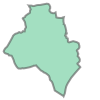

In [208]:
boundary_poly

#### 2. Reproject rasters

In [9]:
from osgeo import gdal

In [15]:
path = 'data'
tif_10_path = os.path.join(path, '10yr_Kampala.tif')
tif_50_path = os.path.join(path, '50yr_Kampala.tif')
tif_100_path = os.path.join(path, '100yr_Kampala.tif')

tif_10_proj_path = os.path.join(path, '10yr_Kampala_proj.tif')
tif_50_proj_path = os.path.join(path, '50yr_Kampala_proj.tif')
tif_100_proj_path = os.path.join(path, '100yr_Kampala_proj.tif')

In [13]:
test = rasterio.open(tif_10_path)
test.crs

CRS.from_dict(init='epsg:21096')

In [17]:
# Reproject rasters

input_raster = gdal.Open(tif_10_path)
output_raster = os.path.join(tif_10_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

input_raster = gdal.Open(tif_50_path)
output_raster = os.path.join(tif_50_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

input_raster = gdal.Open(tif_100_path)
output_raster = os.path.join(tif_100_proj_path)
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1a400737e0> >

#### 3. Sample rasters for flood depth

In [252]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [253]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [244]:
gn.example_edge(G2, 5)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a4093e0f0>})
(6241026052, 2829219868, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 131.63500000000002, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a48920438>})
(6241026052, 6240996975, {'osmid': 666585325, 'highway': 'residential', 'oneway': False, 'length': 167.02300000000002, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a5ddd0f98>})
(1470693384, 579992568, {'osmid': 45512650, 'highway': 'residential', 'oneway': False, 'length': 24.194, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a4804e7f0>})
(1470693384, 6227375328, {'osmid': 665305898, 'highway': 'residential', 'oneway': False, 'length': 5.359, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a4804e4e0>})


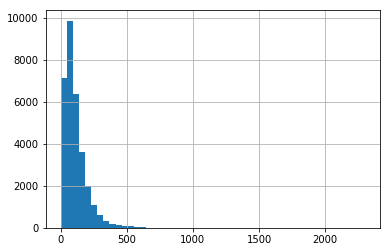

In [245]:
edge_gdf = edge_gdf.sort_values(by = 'length', ascending = False)
edge_gdf['length'].hist(bins = 50)

In [270]:
import importlib
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 100,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 6830 unique edge(s) longer than 100. 
Beginning new node creation...
33796 new edges added and 13401 removed to bring total edges to 52015
10068 new nodes added to bring total nodes to 23764


In [255]:
G2.number_of_nodes()

13696

In [256]:
G3.number_of_nodes()

23199

In [257]:
G2.number_of_edges()

31620

In [258]:
G3.number_of_edges()

18219

In [266]:
print(list(G2.edges(data = True))[0][2]['Wkt'])

LINESTRING (32.5916098 0.3487386, 32.5915968 0.3485911, 32.5915749 0.3483558)


In [109]:
G = gn.sample_raster(G, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G = gn.sample_raster(G, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G = gn.sample_raster(G, tif_100_proj_path, property_name = 'flood_depth_100_yr')

In [110]:
node_gdf = gn.node_gdf_from_graph(G)
edge_gdf = gn.edge_gdf_from_graph(G)

[Text(0, 0.5, 'number of junctions'),
 Text(0.5, 0, 'water depth (meters)'),
 Text(0.5, 1.0, 'Water depths for flooded junctions')]

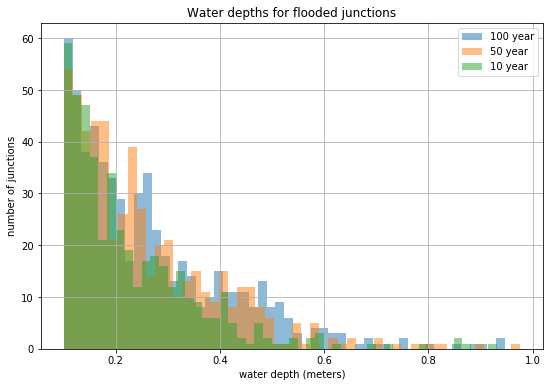

In [67]:
bins = 50

f,ax = plt.subplots(figsize=[9,6])
flood_df.flood_depth_100_yr[(flood_df.flood_depth_100_yr>0) & (flood_df.flood_depth_100_yr<1)].hist(ax=ax,label='100 year',alpha=0.5,bins=bins)
flood_df.flood_depth_50_yr[(flood_df.flood_depth_50_yr>0) & (flood_df.flood_depth_50_yr<1)].hist(ax=ax,label='50 year',alpha=0.5,bins=bins)
flood_df.flood_depth_10_yr[(flood_df.flood_depth_10_yr>0) & (flood_df.flood_depth_10_yr<1)].hist(ax=ax,label='10 year',alpha=0.5,bins=bins)
plt.legend()
ax.set(xlabel="water depth (meters)", ylabel='number of junctions',title = 'Water depths for flooded junctions')


In [ ]:
f,ax = plt.subplots(figsize=[9,6])
sns.distplot(flood_df.flood_depth_100_yr[(flood_df.flood_depth_100_yr>0) & (flood_df.flood_depth_100_yr<1)],bins=bins,ax = ax, color = 'b')
sns.distplot(flood_df.flood_depth_50_yr[(flood_df.flood_depth_50_yr>0) & (flood_df.flood_depth_50_yr<1)], bins=bins,ax=ax, color='g')
sns.distplot(flood_df.flood_depth_10_yr[(flood_df.flood_depth_10_yr>0) & (flood_df.flood_depth_10_yr<1)], bins=bins,ax=ax, color='r')
#ax.set_title('Firms in Kampala: What proportion of key business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(['100 yr','50 yr', '10 yr'])
ax.set(xlabel="water depth", ylabel='percent of junctions',title = 'Water depths for flooded junctions');

#### 4. How much of the network does this affect?
Is it a big effect, or are only a small minority of junctions flooded, hence not much of the network degrades?

In [111]:
n_nodes = flood_df.shape[0]
n_edges = edge_gdf.shape[0]

[Text(0, 0.5, '%'),
 Text(0.5, 1.0, 'Percent nodes where water level > 0.4 meters')]

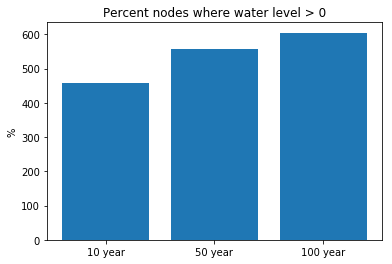

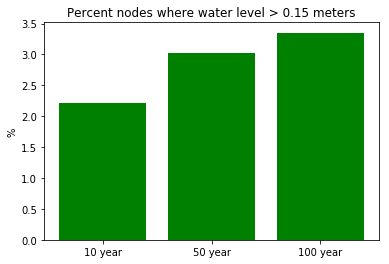

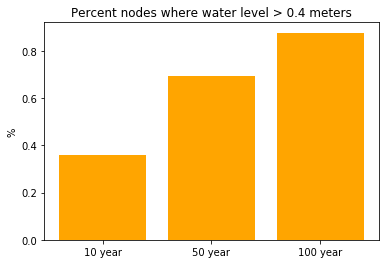

In [305]:
threshold1 = 0.15
threshold2 = 0.4

positive_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>0].count()
positive_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>0].count()
positive_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>0].count()

above_threshold1_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>threshold1].count() / n_nodes * 100
above_threshold1_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>threshold1].count() / n_nodes * 100
above_threshold1_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>threshold1].count() / n_nodes * 100

above_threshold2_10yr_percent =  flood_df.flood_depth_10_yr[flood_df.flood_depth_10_yr>threshold2].count() / n_nodes * 100
above_threshold2_50yr_percent =  flood_df.flood_depth_50_yr[flood_df.flood_depth_50_yr>threshold2].count() / n_nodes * 100
above_threshold2_100yr_percent =  flood_df.flood_depth_100_yr[flood_df.flood_depth_100_yr>threshold2].count() / n_nodes * 100

f,ax = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [positive_10yr_percent,positive_50yr_percent,positive_100yr_percent]
plt.bar(labels,values)
ax.set(title = 'Percent nodes where water level > 0', ylabel = '%')

f1,ax1 = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [above_threshold1_10yr_percent,above_threshold1_50yr_percent,above_threshold1_100yr_percent]
ax1.bar(labels,values,color='g')
ax1.set(title = 'Percent nodes where water level > {} meters'.format(threshold1), ylabel = '%')

f2,ax2 = plt.subplots()
labels = ['10 year','50 year','100 year']
values = [above_threshold2_10yr_percent,above_threshold2_50yr_percent,above_threshold2_100yr_percent]
ax2.bar(labels,values,color='orange')
ax2.set(title = 'Percent nodes where water level > {} meters'.format(threshold2), ylabel = '%')


### --> Basically it doesn't affect that many of the nodes.
* Only 4% of nodes have any water at all.
* Only 2% have more than 15 centimeters in a 10-yr event (3% in a 100-yr event)
* Less than 1% are knocked out according to a 40-centimeter threshold.

Should we buffer the nodes and take the largest value within the surrounding x pixels?

#### 5. Create the degraded road networks

In [113]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [114]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [115]:
gn.example_node(G)

(6241026052, {'y': 0.3487386, 'x': 32.5916098, 'osmid': 6241026052, 'flood_depth_10_yr': -32767.0, 'flood_depth_50_yr': -32767.0, 'flood_depth_100_yr': -32767.0})


In [130]:
my_flood_depth = 0.4
fail_value = 999999999999999

G_flood10 = G.copy()
G_flood50 = G.copy()
G_flood100 = G.copy()

print("10 year:")
G_flood10 = gn.disrupt_network(G_flood10, 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G_flood50, 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G_flood100, 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 49
edges disrupted: 155

50 year:
nodes disrupted: 95
edges disrupted: 295

100 year:
nodes disrupted: 120
edges disrupted: 364


In [120]:
print("15 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (304/n_nodes * 100, 921/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (415/n_nodes * 100, 1213/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (459/n_nodes * 100, 1347/n_edges * 100))

15 centimeter threshold:
10-year flood disrupts 2.22 % of nodes and 2.91 % of edges
50-year flood disrupts 3.03 % of nodes and 3.84 % of edges
100-year flood disrupts 3.35 % of nodes and 4.26 % of edges


In [129]:
print("25 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (157/n_nodes * 100, 474/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (221/n_nodes * 100, 658/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (275/n_nodes * 100, 788/n_edges * 100))

25 centimeter threshold:
10-year flood disrupts 1.15 % of nodes and 1.50 % of edges
50-year flood disrupts 1.61 % of nodes and 2.08 % of edges
100-year flood disrupts 2.01 % of nodes and 2.49 % of edges


In [131]:
print("40 centimeter threshold:")
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (49/n_nodes * 100, 155/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (95/n_nodes * 100, 295/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (120/n_nodes * 100, 364/n_edges * 100))

40 centimeter threshold:
10-year flood disrupts 0.36 % of nodes and 0.49 % of edges
50-year flood disrupts 0.69 % of nodes and 0.93 % of edges
100-year flood disrupts 0.88 % of nodes and 1.15 % of edges


#### 6. Get POIs (destination points)

In [ ]:
# Hospitals

In [137]:
bbox = pop_raster.bounds

amenities_hospital = ['hospital']
amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

In [138]:
POIs_health = POIs_health[['amenity','name','lat','lon']]

POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [ ]:
# Business amenities (3300 businesses, stores, gas or mobile phone suppliers, from notebook 4)

In [151]:
POIs_biz = gpd.read_file('data/KM_pois/KM_biz_amenities1')

#### 7. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [142]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [146]:
grid=gpd.read_file('grid_KM.shp')

In [143]:
ES_points = gpd.read_file('data/points_ES_clipped')

#### 8. Visualize Os and Ds

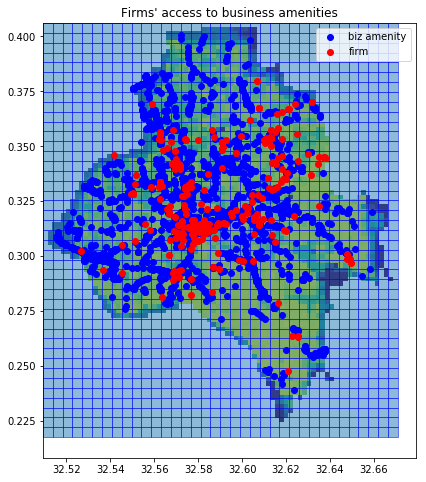

In [157]:
f,ax = plt.subplots(figsize=[8,8])
grid.plot(ax = ax, color=None, edgecolor='b', alpha = 0.5)
show(pop_raster, ax=ax)
POIs_biz.plot(ax=ax, color='b', label = 'biz amenity')
ES_points.plot(ax=ax, color='r', label = 'firm')
plt.title("Firms' access to business amenities")
plt.legend()

#### 9. Calculate travel times

In [159]:
ES_points_nn = gn.pandana_snap(G, ES_points)
POIs_biz_nn = gn.pandana_snap(G, POIs_biz)

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1576: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [160]:
fail_value = 999999999999999

In [161]:
list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)

In [167]:
def calculate_OD(G, origins, destinations, fail_value, weight = 'time'):
    #### Function for generating an origin: destination matrix  ####
    # REQUIRED: G - a graph containing one or more nodes
    #           fail_value - the value to return if the trip cannot be completed (implies some sort of disruption / disconnected nodes)
    #           origins - a list of the node IDs to treat as origins points
    #           destinations - a list of the node IDs to treat as destination points
    # OPTIONAL: weight - use edge weight of 'time' unless otherwise specified
    # RETURNS:  a numpy matrix of format OD[o][d] = shortest time possible
    # -------------------------------------------------------------------------#

    OD = np.zeros((len(origins), len(destinations)))

    for o in range(0, len(origins)):
        origin = origins[o]
        results_dict = nx.single_source_dijkstra_path_length(G, origin, cutoff = None, weight = weight)

        for d in range(0, len(destinations)):
            destination = destinations[d]
            if destination in results_dict.keys():
                OD[o][d] = results_dict[destination]
            else:
                OD[o][d] = fail_value

    return OD

In [170]:
baseline_OD_bizaccess = calculate_OD(G, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')

In [171]:
flood_OD_bizaccess_10yr = calculate_OD(G_flood10, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')
flood_OD_bizaccess_50yr = calculate_OD(G_flood50, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')
flood_OD_bizaccess_100yr = calculate_OD(G_flood100, list_of_nearest_nodes_ES, list_of_nearest_nodes_POIs_biz, fail_value, weight='time')

In [273]:
baseline_OD_bizaccess_df = pd.DataFrame(baseline_OD_bizaccess, index = list_of_nearest_nodes_ES, columns = list_of_nearest_nodes_POIs_biz)
flood_OD_bizaccess_10yr_df = pd.DataFrame(flood_OD_bizaccess_10yr)
flood_OD_bizaccess_50yr_df = pd.DataFrame(flood_OD_bizaccess_50yr)
flood_OD_bizaccess_100yr_df = pd.DataFrame(flood_OD_bizaccess_100yr)

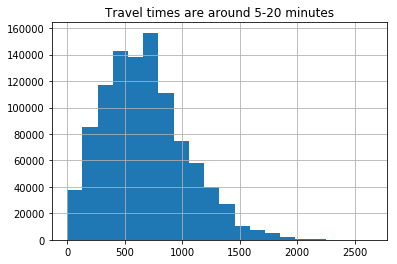

In [188]:
pd.Series(baseline_OD.ravel()).hist(bins=20)
plt.title("Travel times are around 5-20 minutes");

In [191]:
threshold

900

#### 10. How many amenities accessible within x minutes?

In [185]:
baseline_OD_bizaccess_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,3297,3298,3299,3300,3301,3302,3303,3304,3305,3306
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,...,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,1013.149236,779.777926,457.838311,490.838021,465.098382,499.395602,561.793610,641.405239,678.659190,877.247337,...,521.724805,509.223158,493.645825,493.645825,481.068086,485.659577,881.733101,486.231028,500.958964,588.736254
std,324.249214,316.825771,260.931509,277.261255,260.606822,287.137595,291.643322,301.583221,307.386784,234.659734,...,206.521071,210.966590,213.913992,213.913992,214.609985,217.351952,367.715635,271.583669,209.707425,226.484231
min,11.995560,57.040800,0.000000,18.888360,17.608200,31.418884,89.661420,42.111300,42.074160,243.978840,...,94.094730,80.749980,87.324960,87.324960,86.991634,100.686600,66.835560,43.629000,57.699360,90.106560
25%,787.437630,558.632629,223.462860,248.271004,240.737329,240.447201,308.528280,380.258700,415.478790,778.066860,...,369.654930,394.825995,362.031150,362.031150,335.599110,330.848659,601.763970,250.912410,392.633430,419.221500
50%,929.447100,744.879810,435.286800,467.052300,480.162737,485.122607,529.832760,593.090220,631.944030,842.993820,...,504.540420,452.972310,442.167390,442.167390,432.151174,451.088289,933.513000,466.802310,444.195120,557.848230
75%,1367.323140,995.122635,621.547200,742.792719,713.669220,764.360310,815.820510,908.727990,952.428630,1018.025745,...,600.877740,604.052925,592.031295,592.031295,568.901241,572.083230,1108.074120,720.015510,587.190420,726.051981
max,1772.385840,1759.697310,1375.945440,1310.688030,1276.971990,1238.428050,1354.063710,1395.673530,1403.375190,1688.936580,...,1635.798390,1633.321080,1653.851700,1653.851700,1653.518374,1660.046460,2183.561910,1319.815950,1610.270460,1607.701560


In [205]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [200]:
baseline_number_reachable = baseline_OD_bizaccess_df[baseline_OD_bizaccess_df < threshold].count(axis=1)
flood_10_number_reachable = flood_OD_bizaccess_10yr_df[flood_OD_bizaccess_10yr_df < threshold].count(axis=1)
flood_50_number_reachable = flood_OD_bizaccess_50yr_df[flood_OD_bizaccess_50yr_df < threshold].count(axis=1)
flood_100_number_reachable = flood_OD_bizaccess_100yr_df[flood_OD_bizaccess_100yr_df < threshold].count(axis=1)

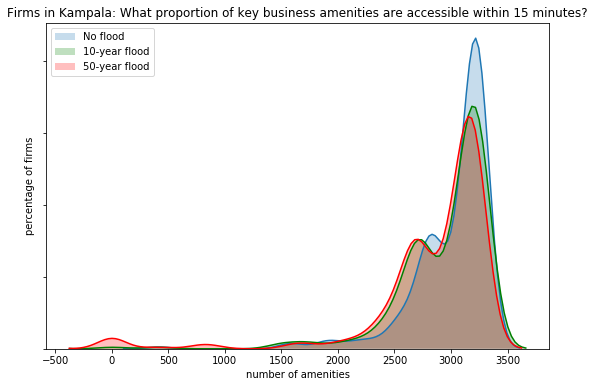

In [206]:
f,ax = plt.subplots(figsize=[9,6])
ax = sns.kdeplot(baseline_number_reachable,shade=True)

sns.kdeplot(flood_10_number_reachable, ax=ax, color='g',shade=True)
#sns.kdeplot(flood_50_number_reachable, ax=ax, color='y',shade=True)
sns.kdeplot(flood_100_number_reachable, ax=ax, color='r',shade=True)
ax.set_title('Firms in Kampala: What proportion of key business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(['No flood','10-year flood','50-year flood'])
ax.set_yticklabels([])
ax.set(xlabel="number of amenities", ylabel='percentage of firms');

In [304]:
new = baseline_OD_bizaccess_df.transpose()
times = []
ids = []

new['dummy'] = 1

for c in range(0, len(new.columns)):
    c = new
    a = new[[c, 'dummy']]
    print(a.columns)
    a.columns = ['real','dummy']
    a = a.sort_values(by = 'real', ascending = True)
    a = a[:5]
    times.append(list(a['real']))
    ids.append(list(a.index))

6247482371
Index([6247482371, 'dummy'], dtype='object')
560478218
Index([560478218, 560478218, 560478218, 560478218, 560478218, 560478218,
       560478218, 560478218, 560478218, 560478218,   'dummy'],
      dtype='object')


ValueError: Length mismatch: Expected axis has 11 elements, new values have 2 elements

In [301]:
for c in list(set(new.columns)):
    print(c)

6247482371
560478218
1691717651
353700888
579895322
1471935516
293956129
560563709
33648167
5652114985
1600640043
2829219887
1692890671
4003314737
1600640050
669207543
293923382
1691717690
1416523323
1425846334
6230806592
6229722689
2081049669
560478279
3381466184
2292399186
293968982
6112576093
4911454815
2096629344
576559201
4915640929
6229407841
6229727844
556859488
6232846947
467025513
576559721
2082532460
6240996975
3548095601
4911401074
295065203
292841585
292861045
2192755320
669207672
560477817
1694553724
556857469
1676610687
2080950400
6227046017
3808231045
467025541
2521199752
3808231049
6219819660
467020429
579896465
576404114
2082531989
292840599
579997847
576559770
2162925210
577387165
576559777
2092077218
1423546020
294013094
294023847
6244744870
3983347369
2081963178
1416513703
475047598
2081945263
2080923825
6194775730
6218700465
579997878
294023863
294023873
5232104134
565626567
556986056
2162925260
3942793420
6243617486
2358781135
6227375313
2082915026
1490333906
dumm